In [1]:
# !pip install cupy-cuda12x

In [2]:
import os
import numpy as np
# import cupy as cp
# import numba as nb
import datetime as dt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import h5py
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from keras.models import Sequential
from keras.optimizers import Adam
# from attention import Attention

In [3]:
len(tf.config.list_physical_devices('GPU'))

1

In [4]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [5]:
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
tf.test.is_gpu_available

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [6]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [8]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
tf.config.experimental.enable_op_determinism()

In [10]:
df = pd.read_csv('F:\Work\Time Series Forecast_Water Levels\Impute_misvalues_hungyen.csv')
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,0,47.0
1,1/1/2008,1,43.0
2,1/1/2008,2,40.0
3,1/1/2008,3,37.0
4,1/1/2008,4,34.0


In [11]:
df['Hour'] = df['Hour'].replace('#NUM!', 0)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64061 entries, 0 to 64060
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        64061 non-null  object 
 1   Hour        64061 non-null  object 
 2   Waterlevel  64061 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB


In [13]:
df.describe()

,Waterlevel
count,64061.000000
mean,138.135113
std,97.020489
min,-26.000000
25%,75.000000
50%,116.000000
75%,171.000000
max,651.000000


In [14]:
df.isnull().sum()

Date          0
Hour          0
Waterlevel    0
dtype: int64

In [15]:
df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,00:00:00,47.0
1,1/1/2008,01:00:00,43.0
2,1/1/2008,02:00:00,40.0
3,1/1/2008,03:00:00,37.0
4,1/1/2008,04:00:00,34.0


In [16]:
df['Hour'] = df['Hour'].astype(str)


df['DateTime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Hour']
        )
df = df.set_index('DateTime')
df.drop(['Date', 'Hour'], 
        axis = 1, inplace = True)

df.head()

,Waterlevel
DateTime,
2008-01-01 00:00:00,47.0
2008-01-01 01:00:00,43.0
2008-01-01 02:00:00,40.0
2008-01-01 03:00:00,37.0
2008-01-01 04:00:00,34.0


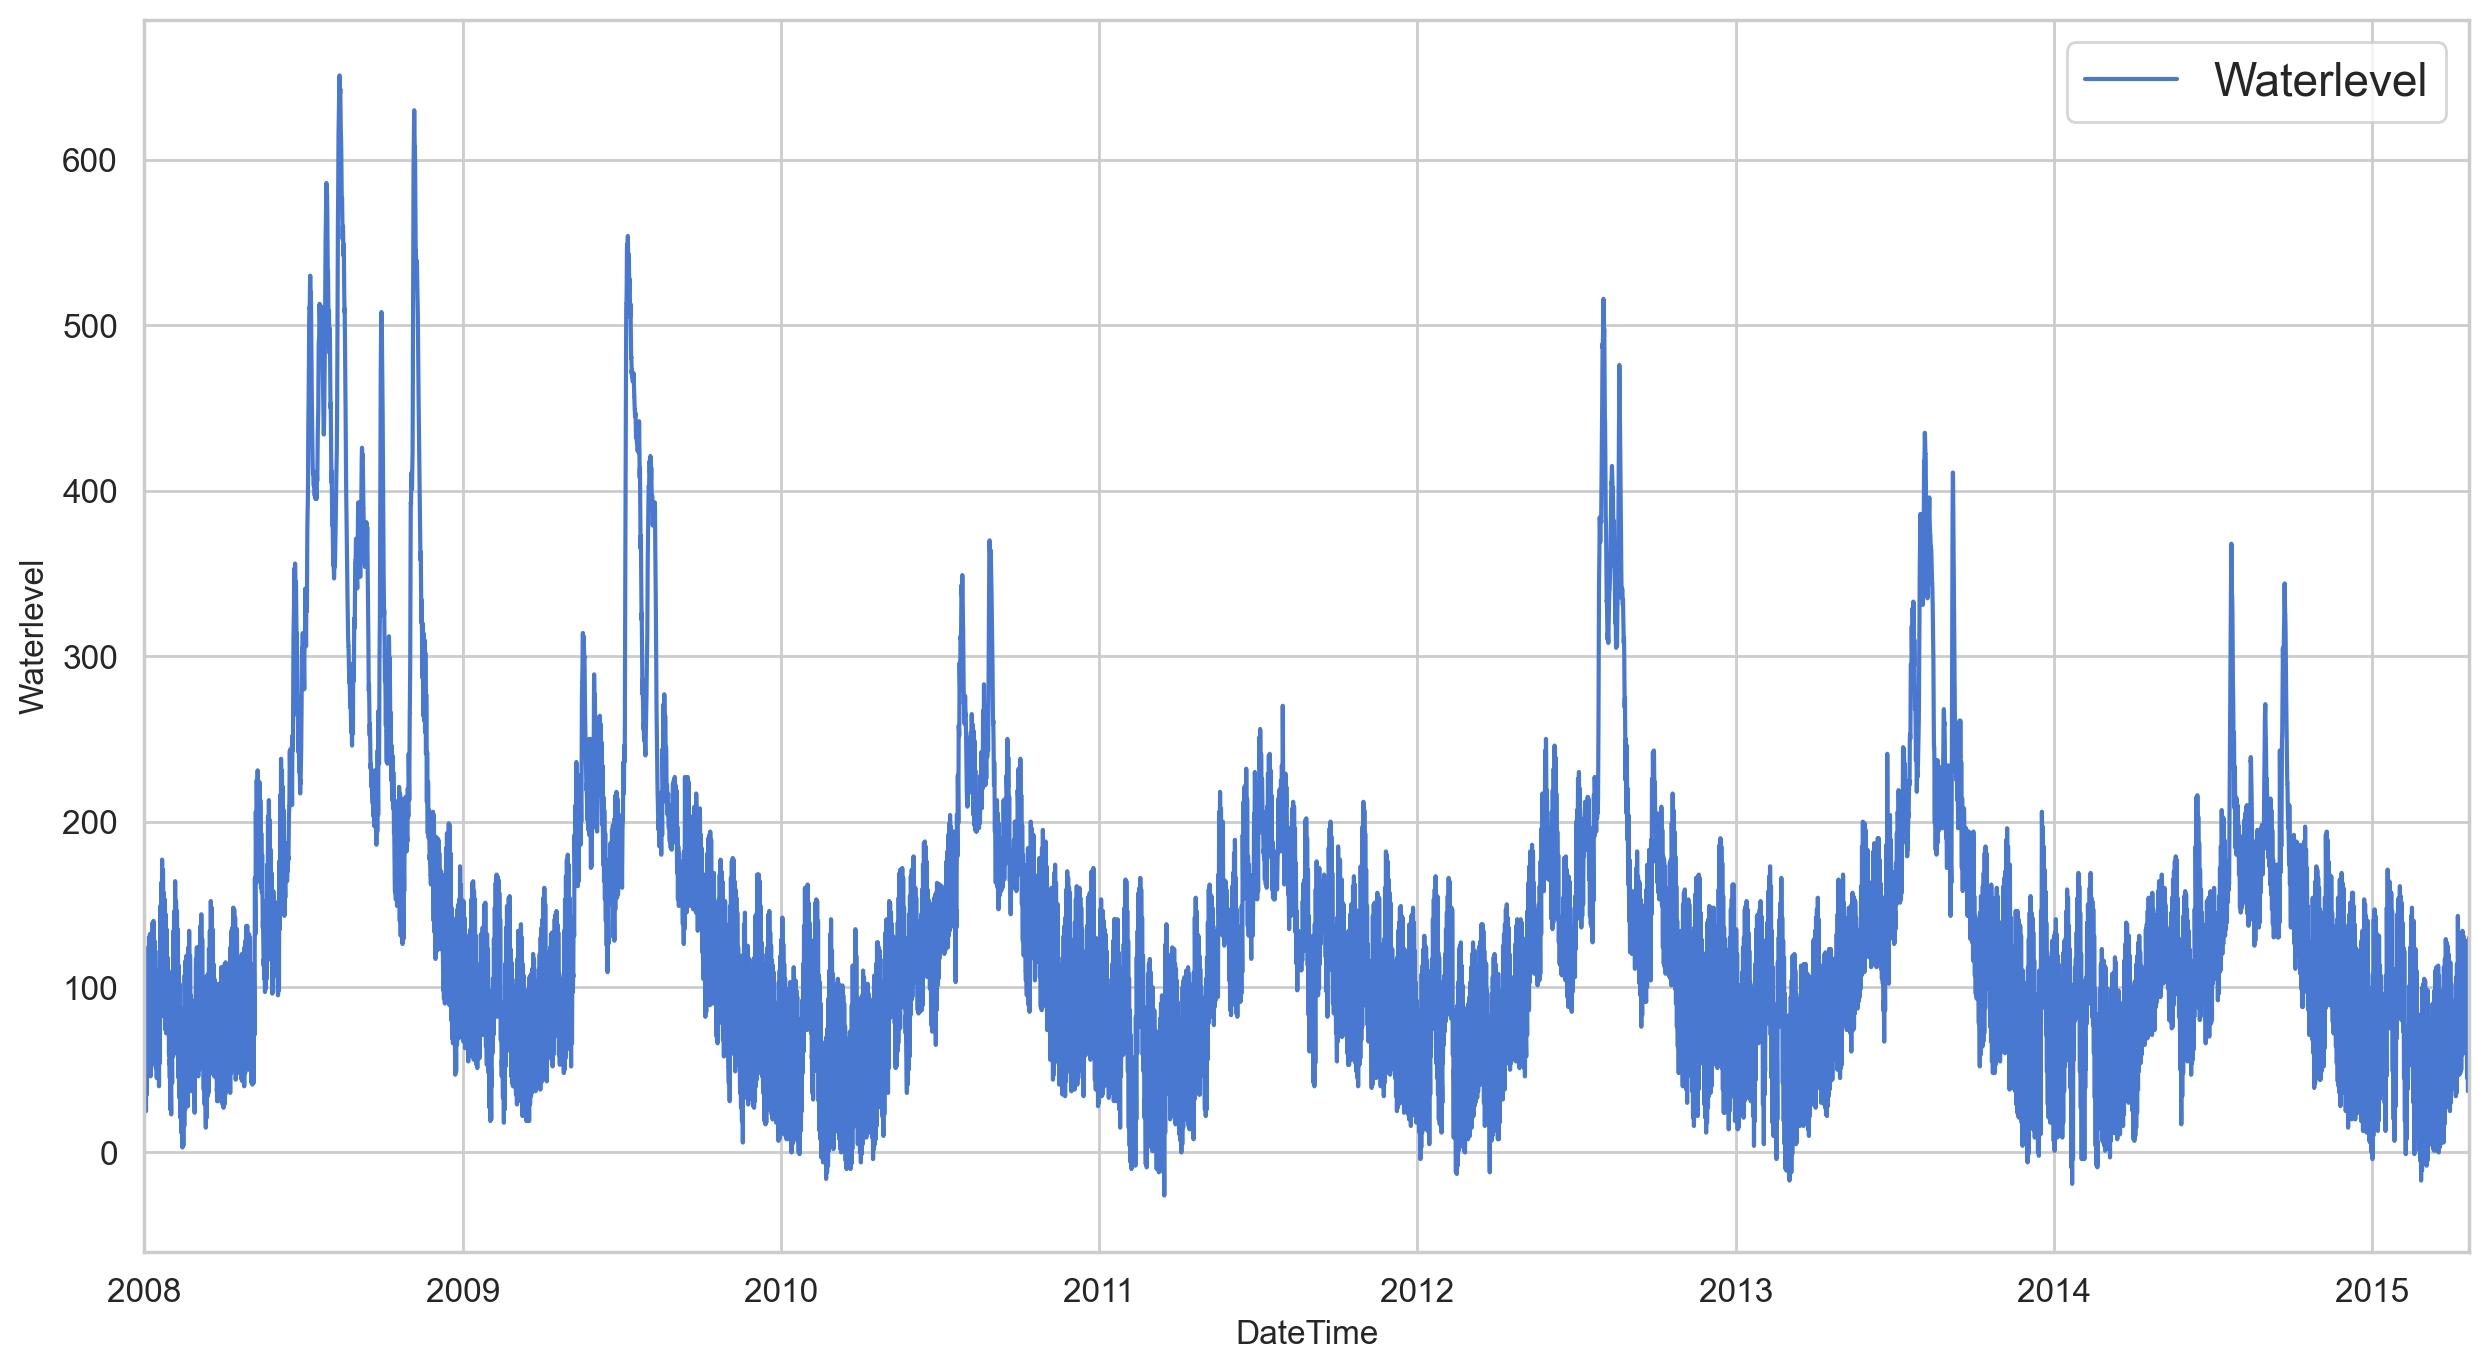

In [17]:
df.plot(y='Waterlevel', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)
plt.show()

In [18]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.85)
train, val, test = df[:train_size].iloc[:, [-1]], df[train_size:val_size].iloc[:, [-1]] , df[val_size:].iloc[:, [-1]]

train, val, test

(                     Waterlevel
 DateTime                       
 2008-01-01 00:00:00        47.0
 2008-01-01 01:00:00        43.0
 2008-01-01 02:00:00        40.0
 2008-01-01 03:00:00        37.0
 2008-01-01 04:00:00        34.0
 ...                         ...
 2013-02-11 05:00:00        86.0
 2013-02-11 06:00:00       100.0
 2013-02-11 07:00:00       115.0
 2013-02-11 08:00:00       128.0
 2013-02-11 09:00:00       134.0
 
 [44842 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2013-02-11 10:00:00       133.0
 2013-02-11 11:00:00       127.0
 2013-02-11 12:00:00       122.0
 2013-02-11 13:00:00       115.0
 2013-02-11 14:00:00       107.0
 ...                         ...
 2014-03-18 14:00:00        46.0
 2014-03-18 15:00:00        54.0
 2014-03-18 16:00:00        61.0
 2014-03-18 17:00:00        65.0
 2014-03-18 18:00:00        65.0
 
 [9609 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2014-03-18 19:00:0

In [19]:
train.shape, val.shape, test.shape

((44842, 1), (9609, 1), (9610, 1))

Text(0, 0.5, 'Waterlevel')

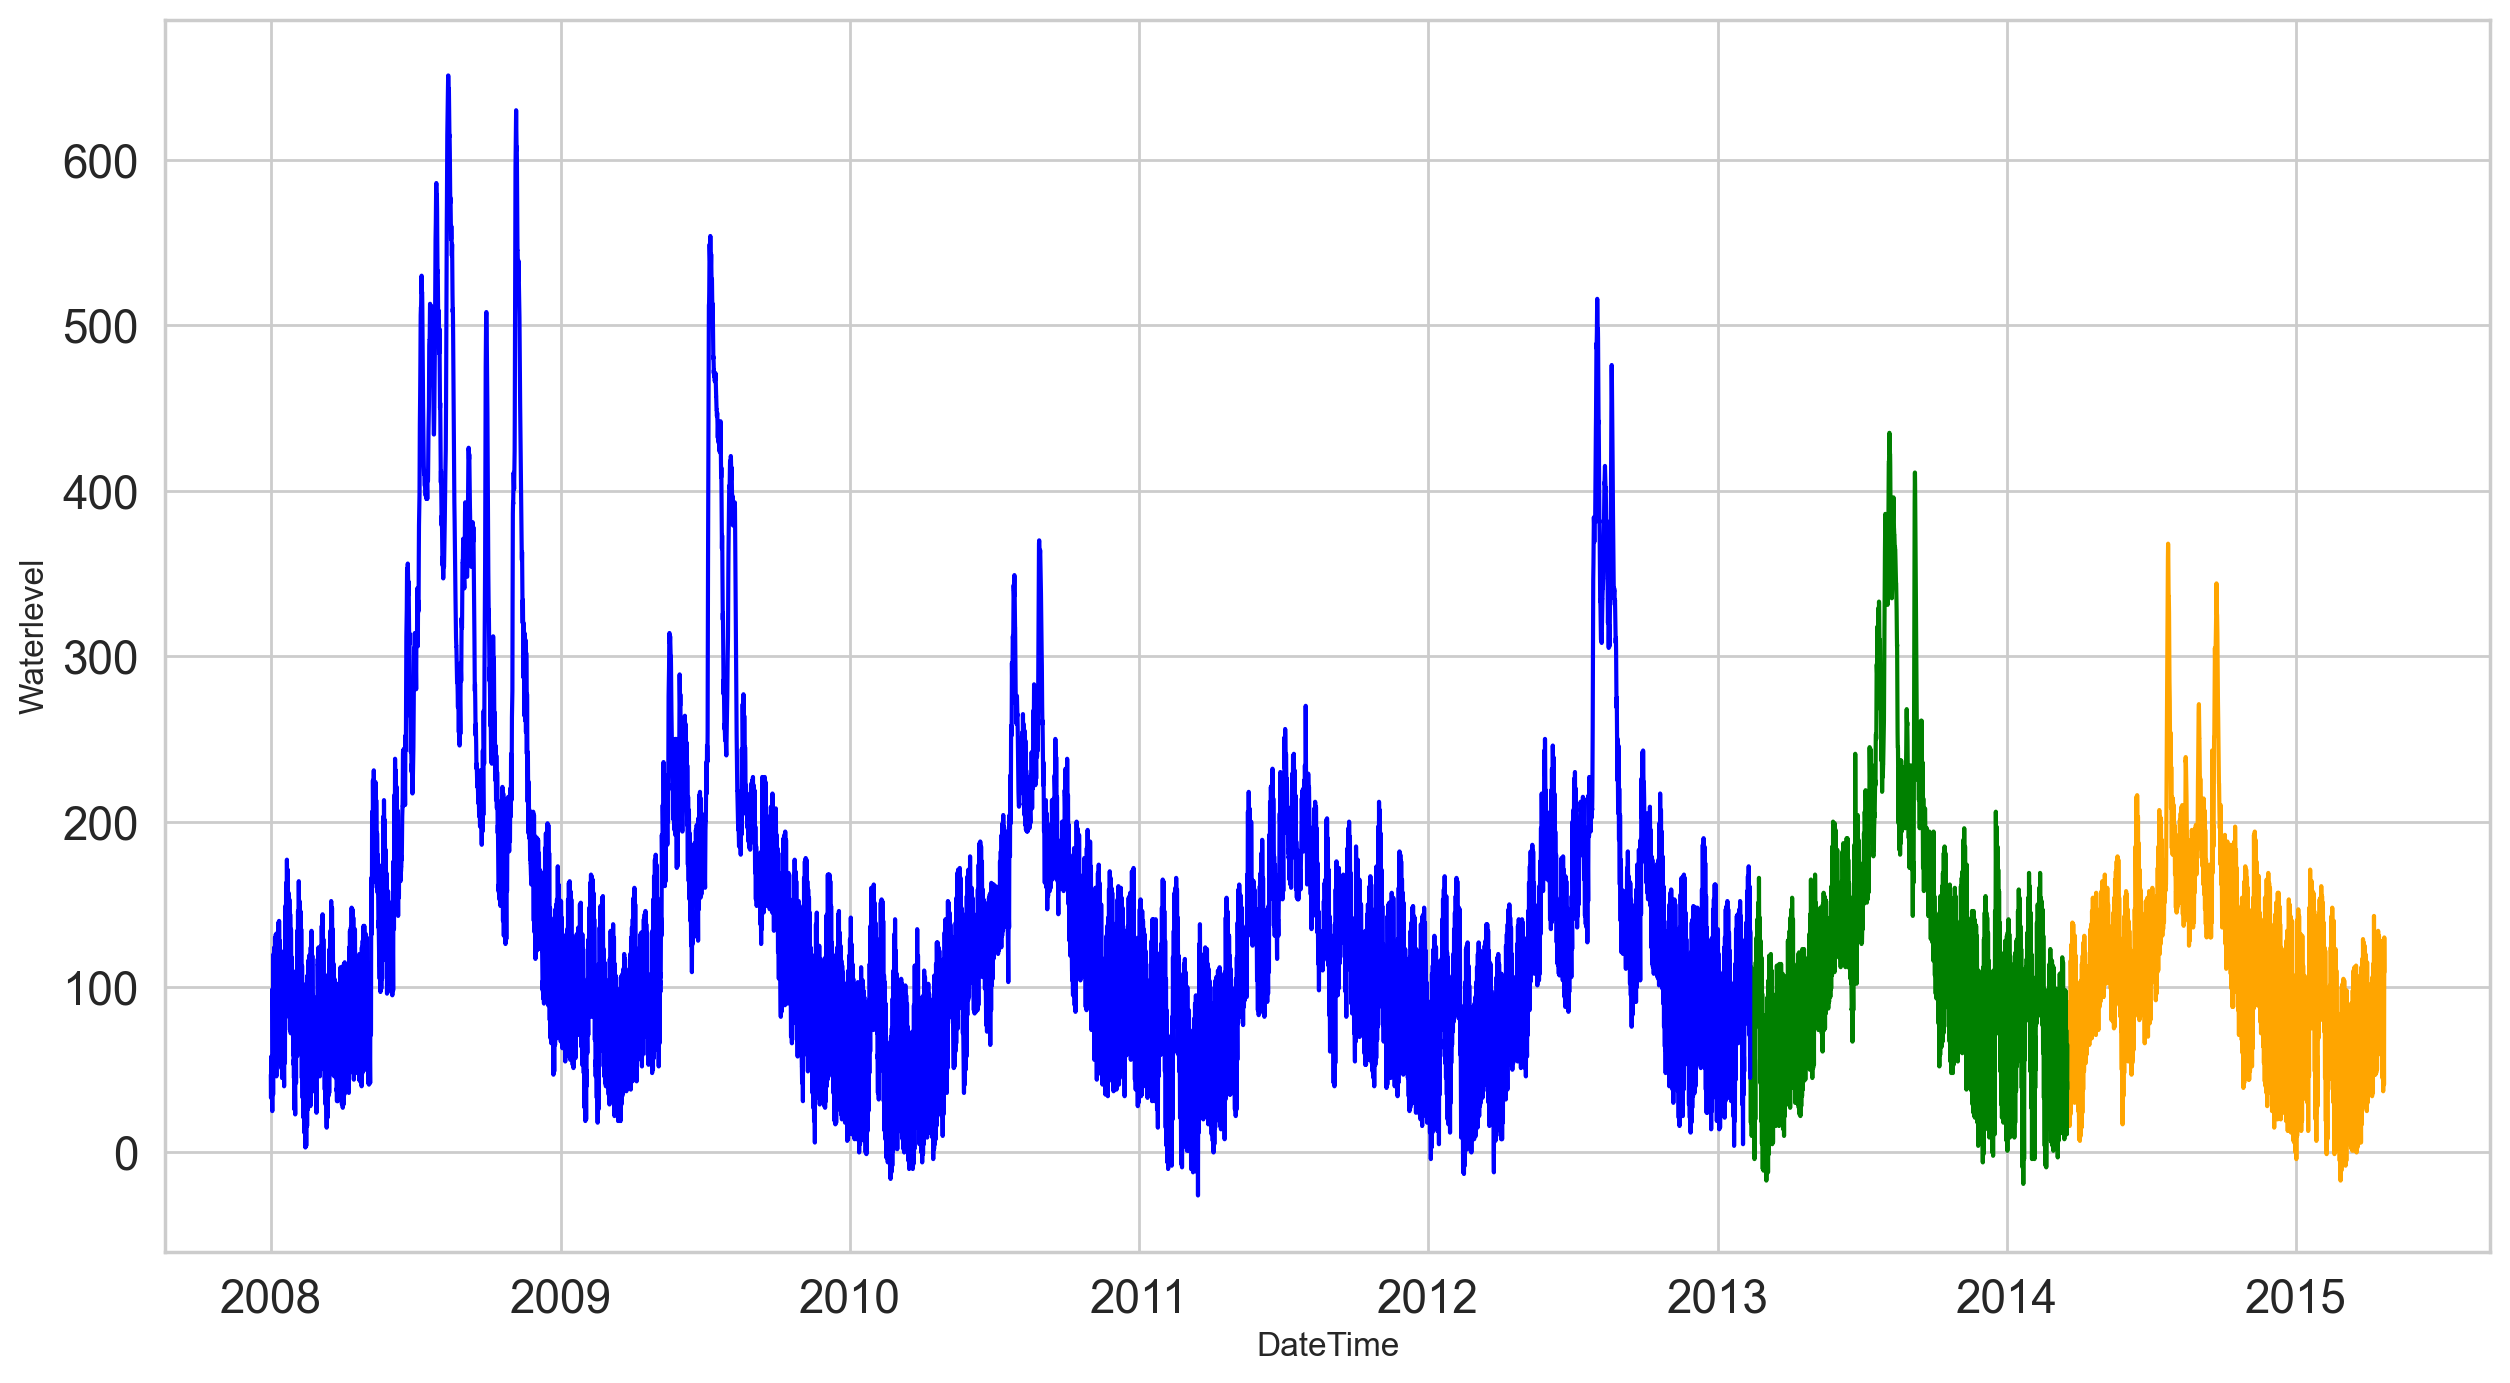

In [20]:
plt.figure(figsize = (15,8))
plt.plot(test.index, test['Waterlevel'], label = "test", color = 'orange')
plt.plot(val.index, val['Waterlevel'], label = "val", color = 'green')
plt.plot(train.index, train['Waterlevel'], label = "train" , color = 'blue')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)

In [21]:
scaler = MinMaxScaler()
train['Waterlevel'] = scaler.fit_transform(train)
val['Waterlevel'] = scaler.transform(val)
test['Waterlevel'] = scaler.transform(test)

In [22]:
train_data = train.values
val_data = val.values
test_data = test.values

In [23]:
timesteps = 164

In [24]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
val_data_timesteps=np.array([[j for j in val_data[i:i+timesteps]] 
                             for i in range(0,len(val_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]


In [25]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_val, y_val = val_data_timesteps[:,:timesteps-1],val_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

x_train, y_train

(array([[0.10782866, 0.10192024, 0.09748892, ..., 0.17282127, 0.16395864,
         0.15509601],
        [0.10192024, 0.09748892, 0.09305761, ..., 0.16395864, 0.15509601,
         0.14623338],
        [0.09748892, 0.09305761, 0.08862629, ..., 0.15509601, 0.14623338,
         0.13737075],
        ...,
        [0.1816839 , 0.17725258, 0.17282127, ..., 0.14327917, 0.16543575,
         0.18611521],
        [0.17725258, 0.17282127, 0.16838996, ..., 0.16543575, 0.18611521,
         0.20827179],
        [0.17282127, 0.16838996, 0.16395864, ..., 0.18611521, 0.20827179,
         0.22747415]]),
 array([[0.14623338],
        [0.13737075],
        [0.12998523],
        ...,
        [0.20827179],
        [0.22747415],
        [0.23633678]]))

In [26]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    squared_error = np.mean((y_true - y_pred)**2)

#     r, _ = pearsonr(y_true, y_pred)
    correlation_matrix = np.corrcoef(y_true, y_pred)
    r = correlation_matrix[0, 1]
    
    
    T = len(y_true)
    max_x = max(y_true)
    min_x = min(y_true)
    
    sim_sum = 0
    for i in range(T):
        sim_sum += 1 / (1 + abs(y_pred[i] - y_true[i]) / (max_x - min_x))
    sim = sim_sum / T
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'SIM': sim,
        'MAE': mae,
        'RMSE': rmse,
        'FSD': fsd,
        'R': r,
        'NSE': nse,
        'MSE' : squared_error
        
    }



In [27]:
# def calculate_r_score(value_lst_missing, value_lst_after):

#     correlation_matrix = np.corrcoef(value_lst_missing, value_lst_after)
#     r_score = correlation_matrix[0, 1]
# #     return r_score

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [29]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), 
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), 
                                 initializer='zeros', trainable=True)        
        super(AttentionLayer, self).build(input_shape)
 
    def call(self, x):
        e = tf.tanh(tf.linalg.matmul(x, self.W) + self.b)
        e = tf.squeeze(e, axis=-1)
        alpha = tf.nn.softmax(e)
        alpha = tf.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [30]:
from tensorflow.keras.models import load_model

In [31]:
model = load_model('cnn_es.h5')

In [38]:
# time = int(input("Enter the first time you want to forecast:"))
time = 200
hours = 120
pred = []

def forecast(model, hours, time):
    pred = []
    # current_window = x_val[-1,:].tolist()
    current_window = x_test[time,:].tolist()
    for i in range(hours):
        # Chuyển current_window thành numpy array khi gọi predict
        y_pred = model.predict(np.asarray([current_window]))[0]
        pred.append(float(y_pred[0]))
        current_window.pop(0)
        current_window.append(pred[-1])
    pred_array = np.array(pred).reshape(-1, 1)
    return pred_array

289/289 [==============================] - 0s 2ms/step


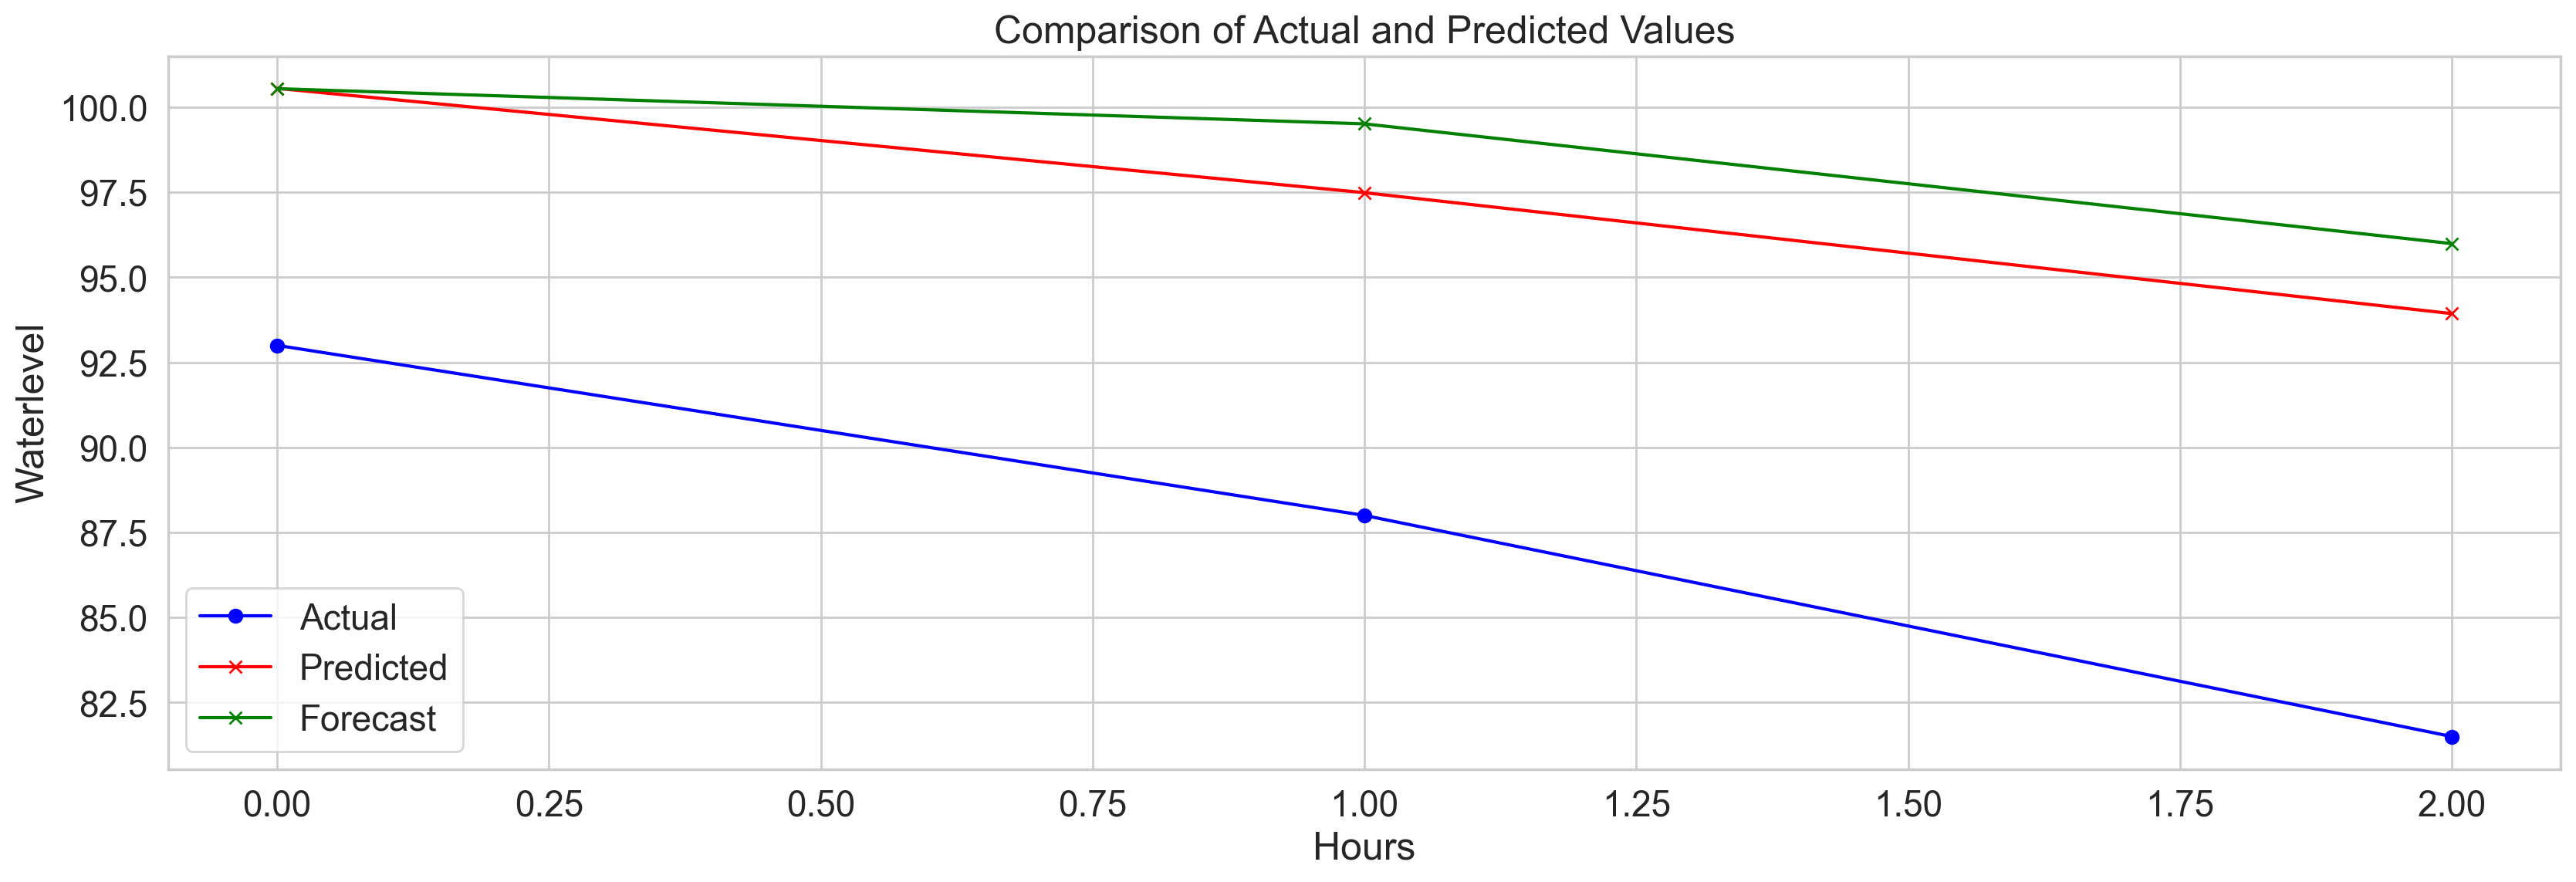

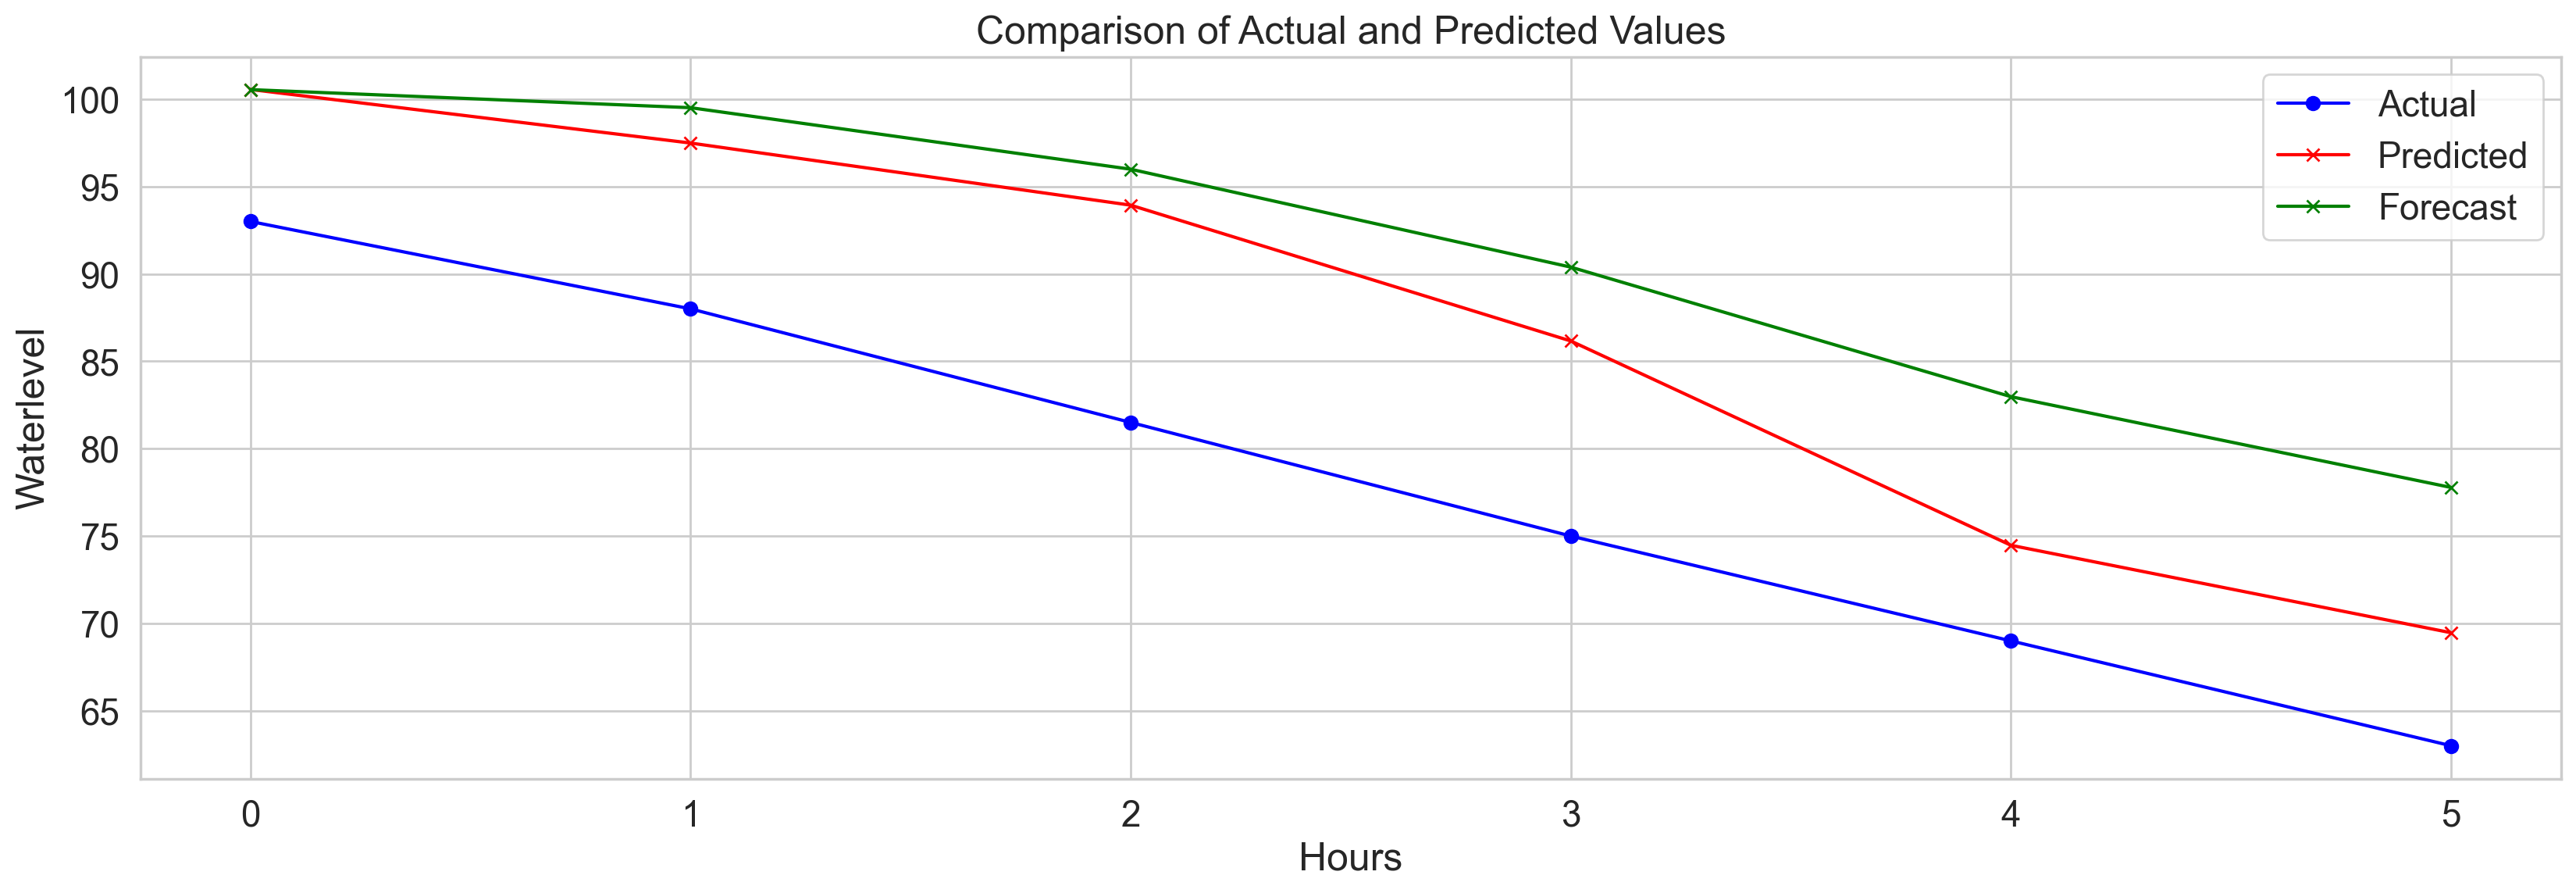

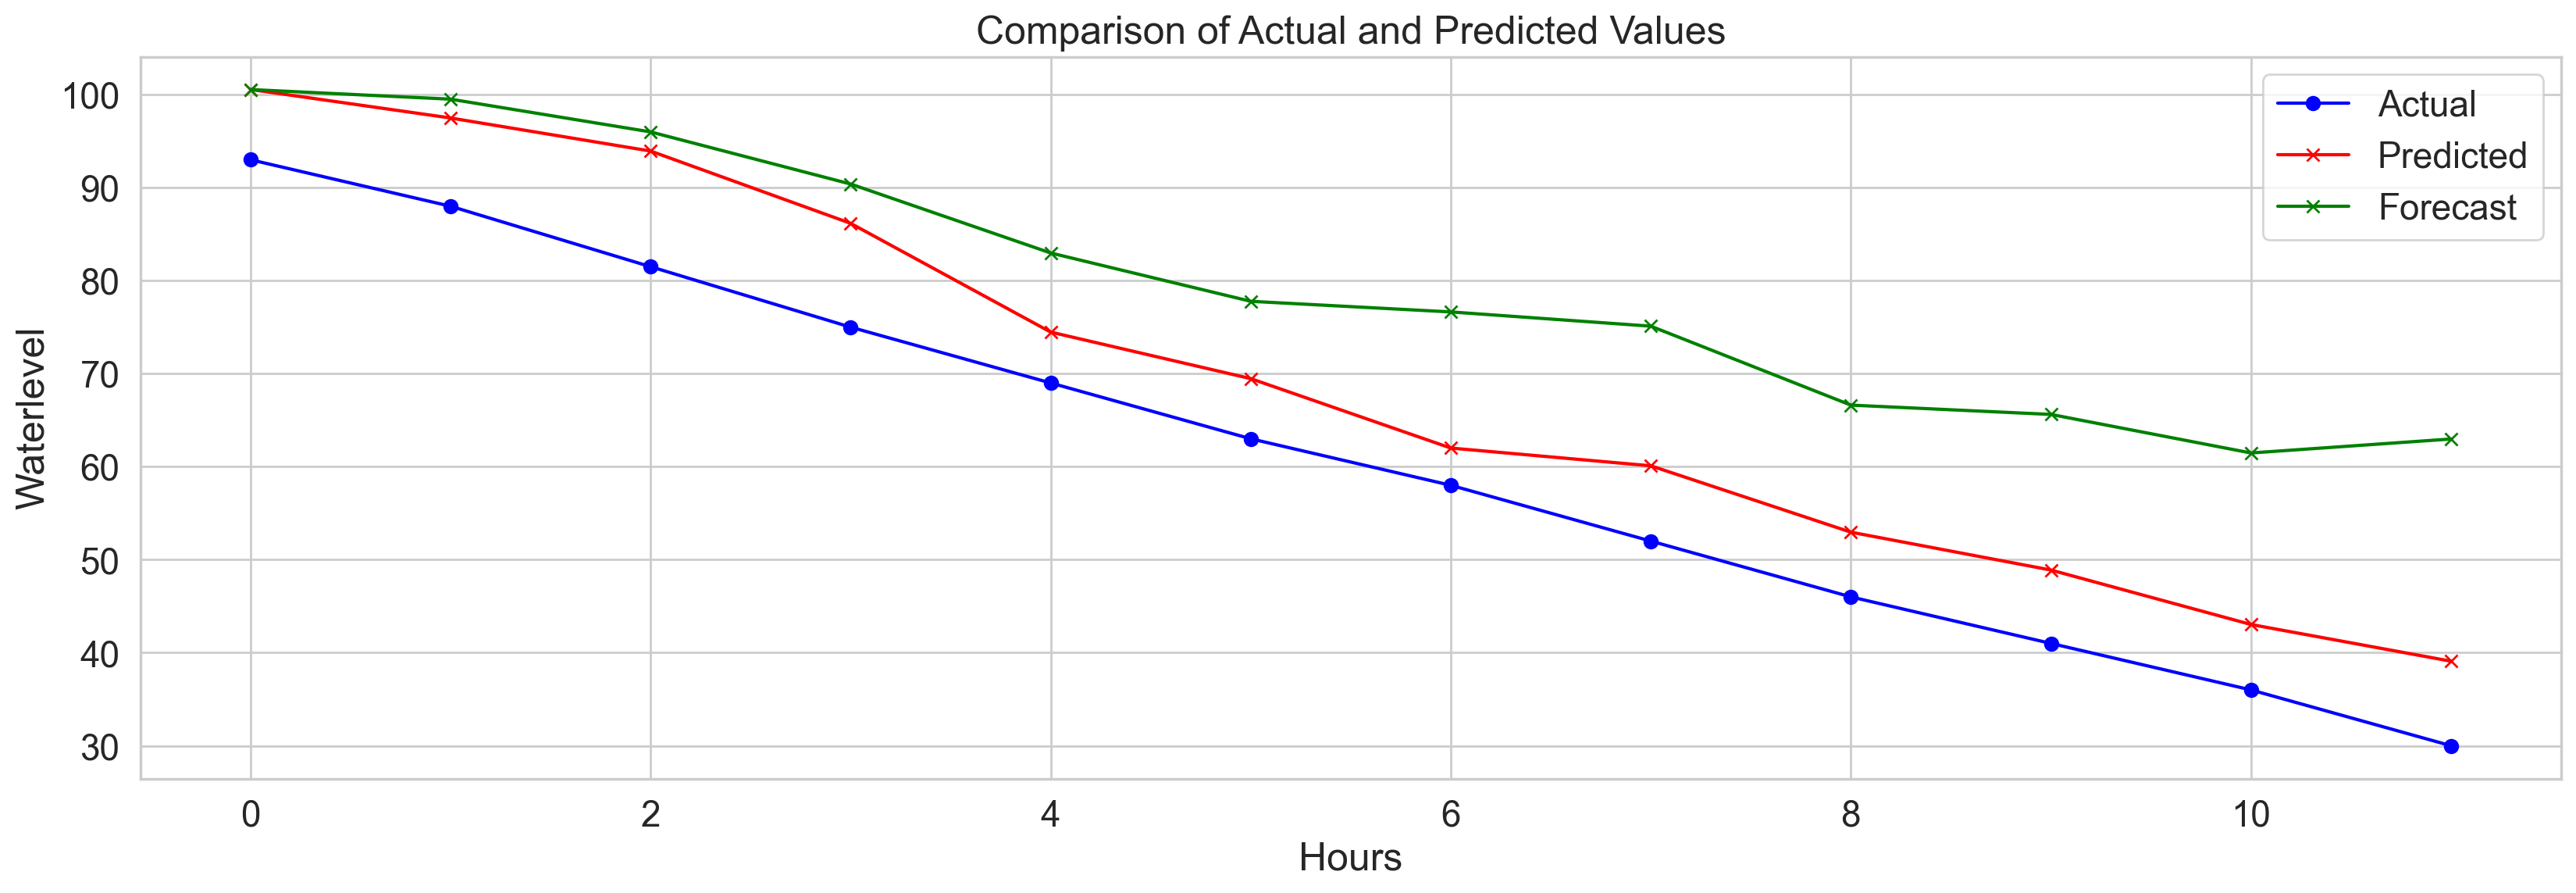

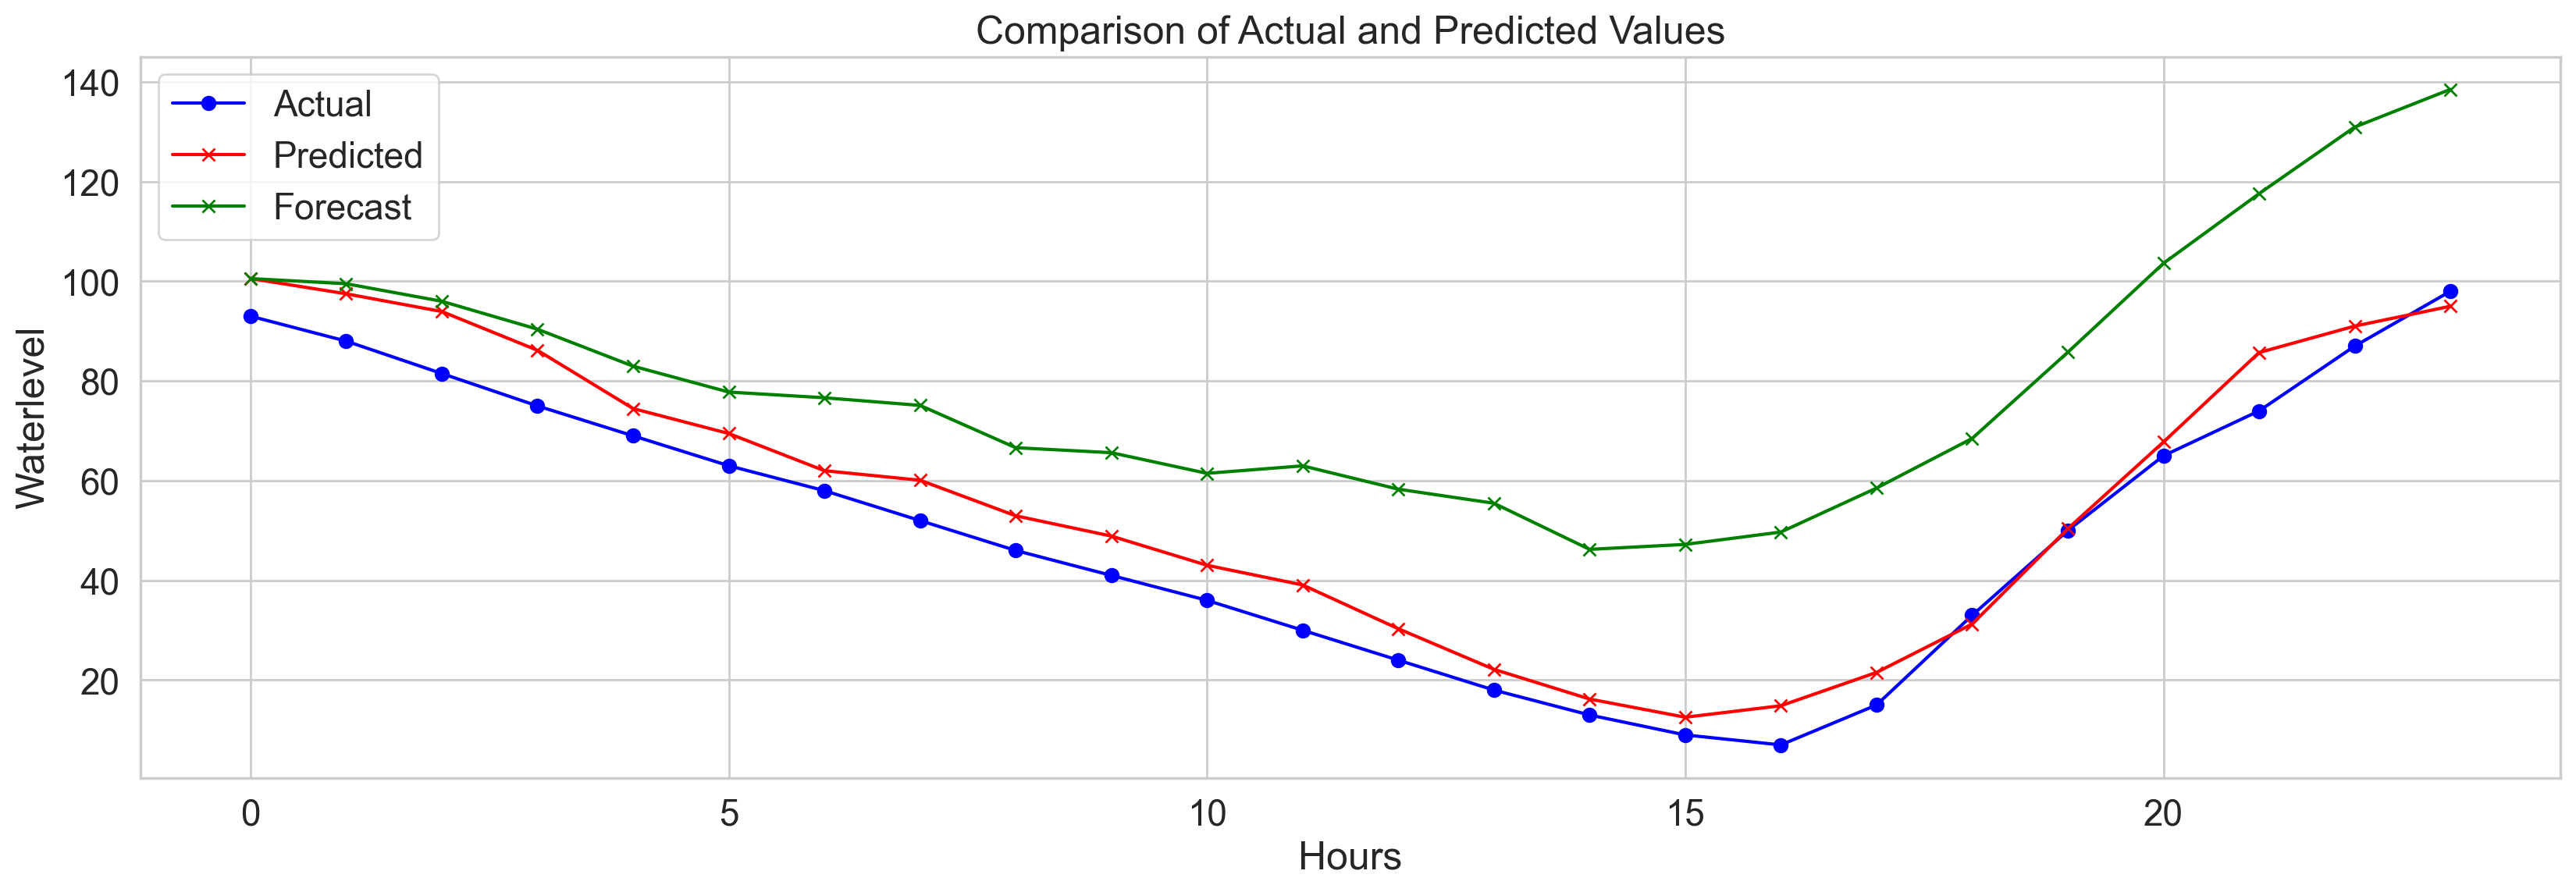

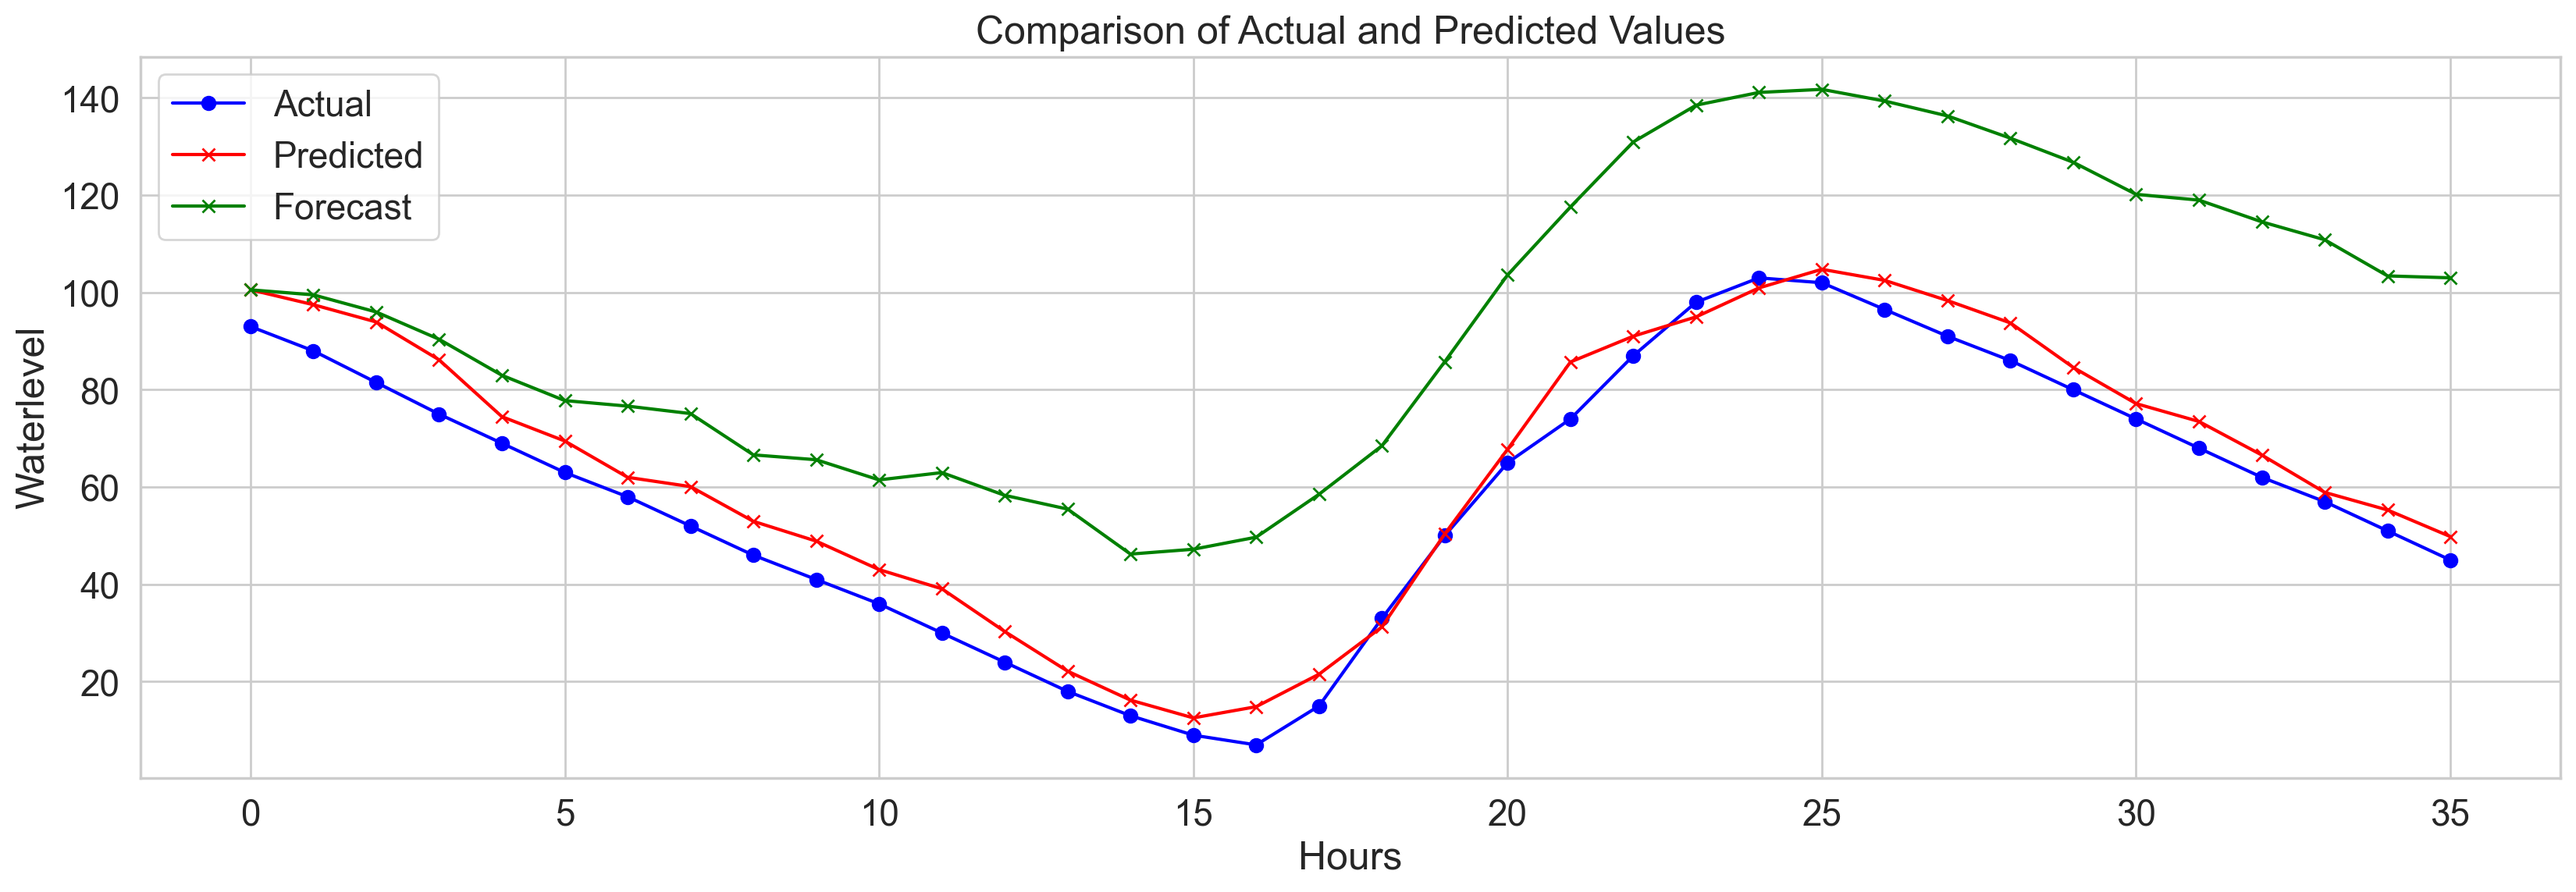

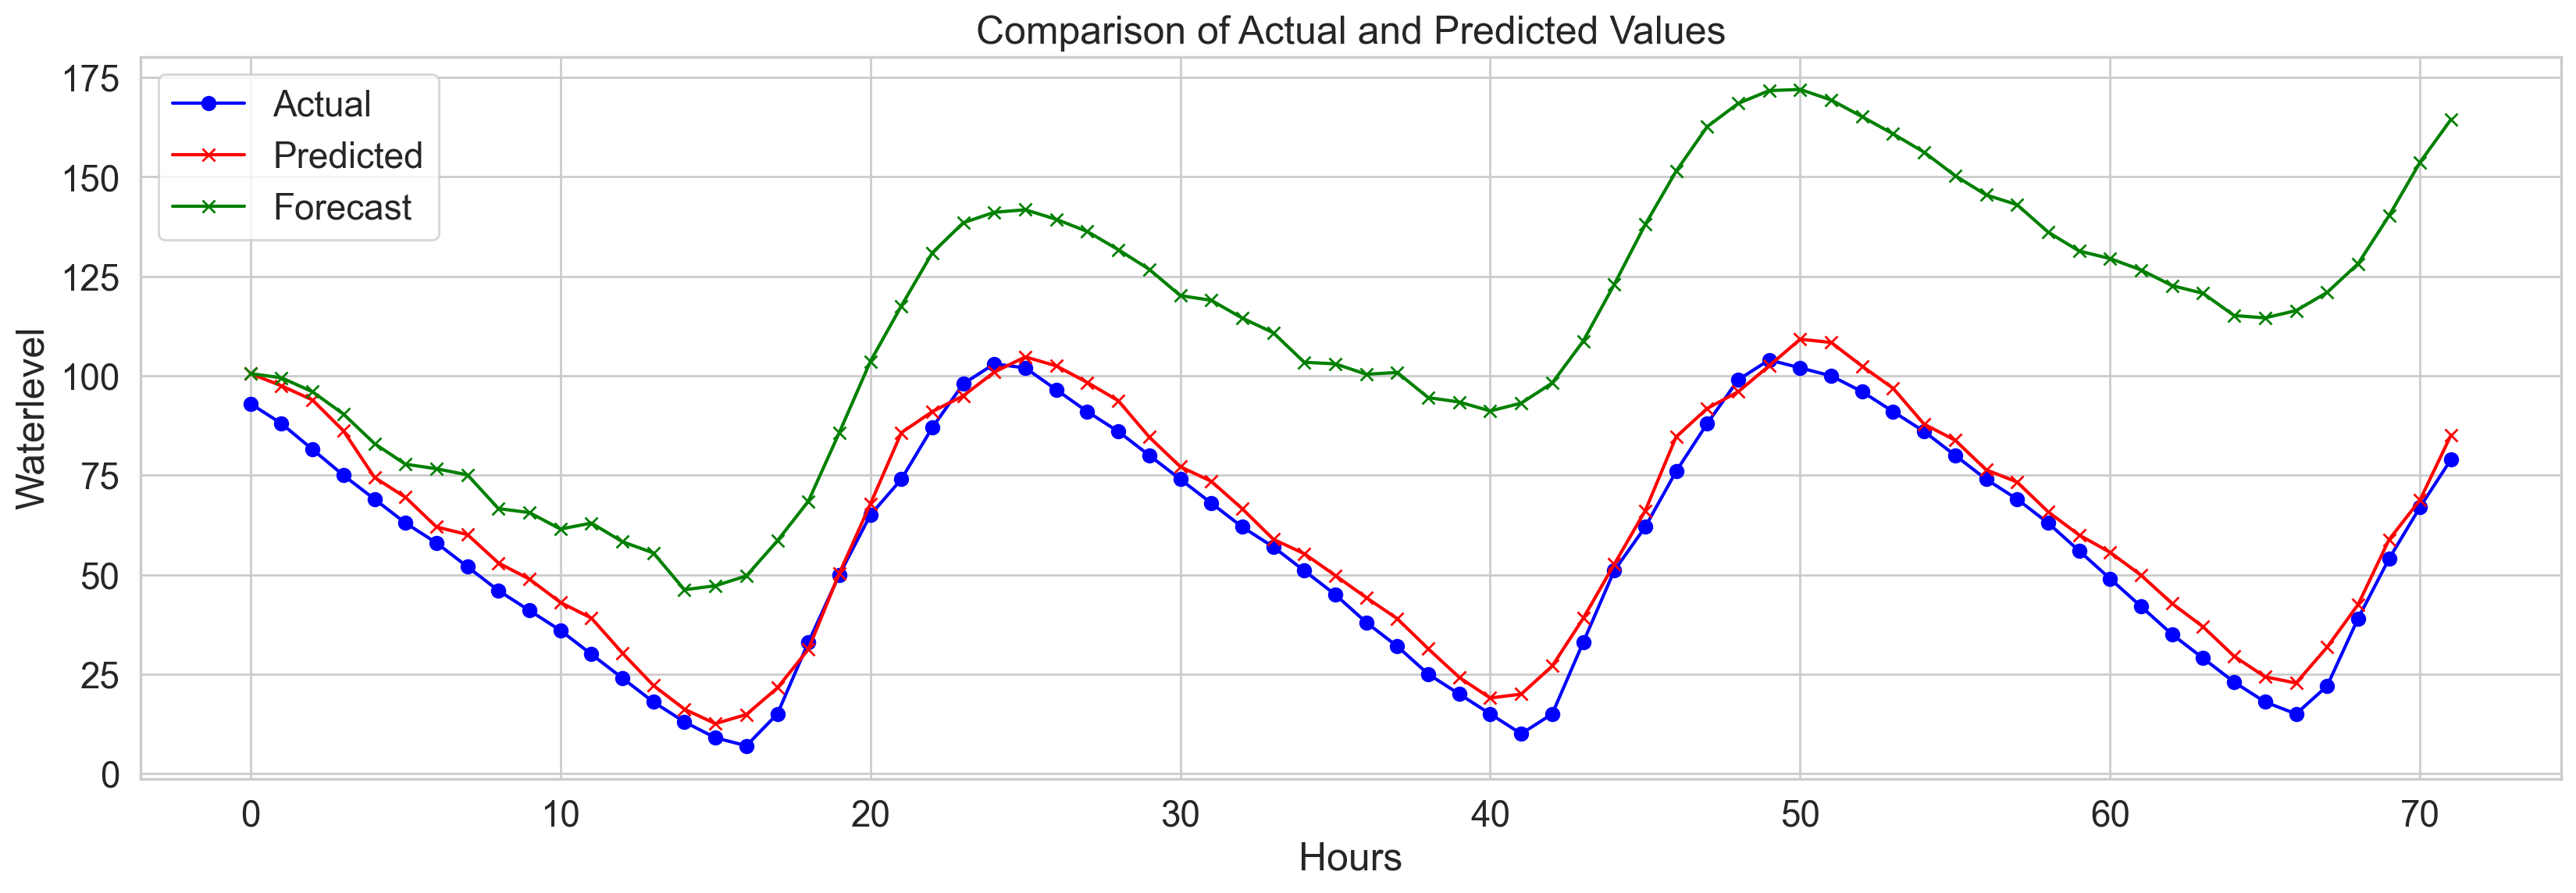

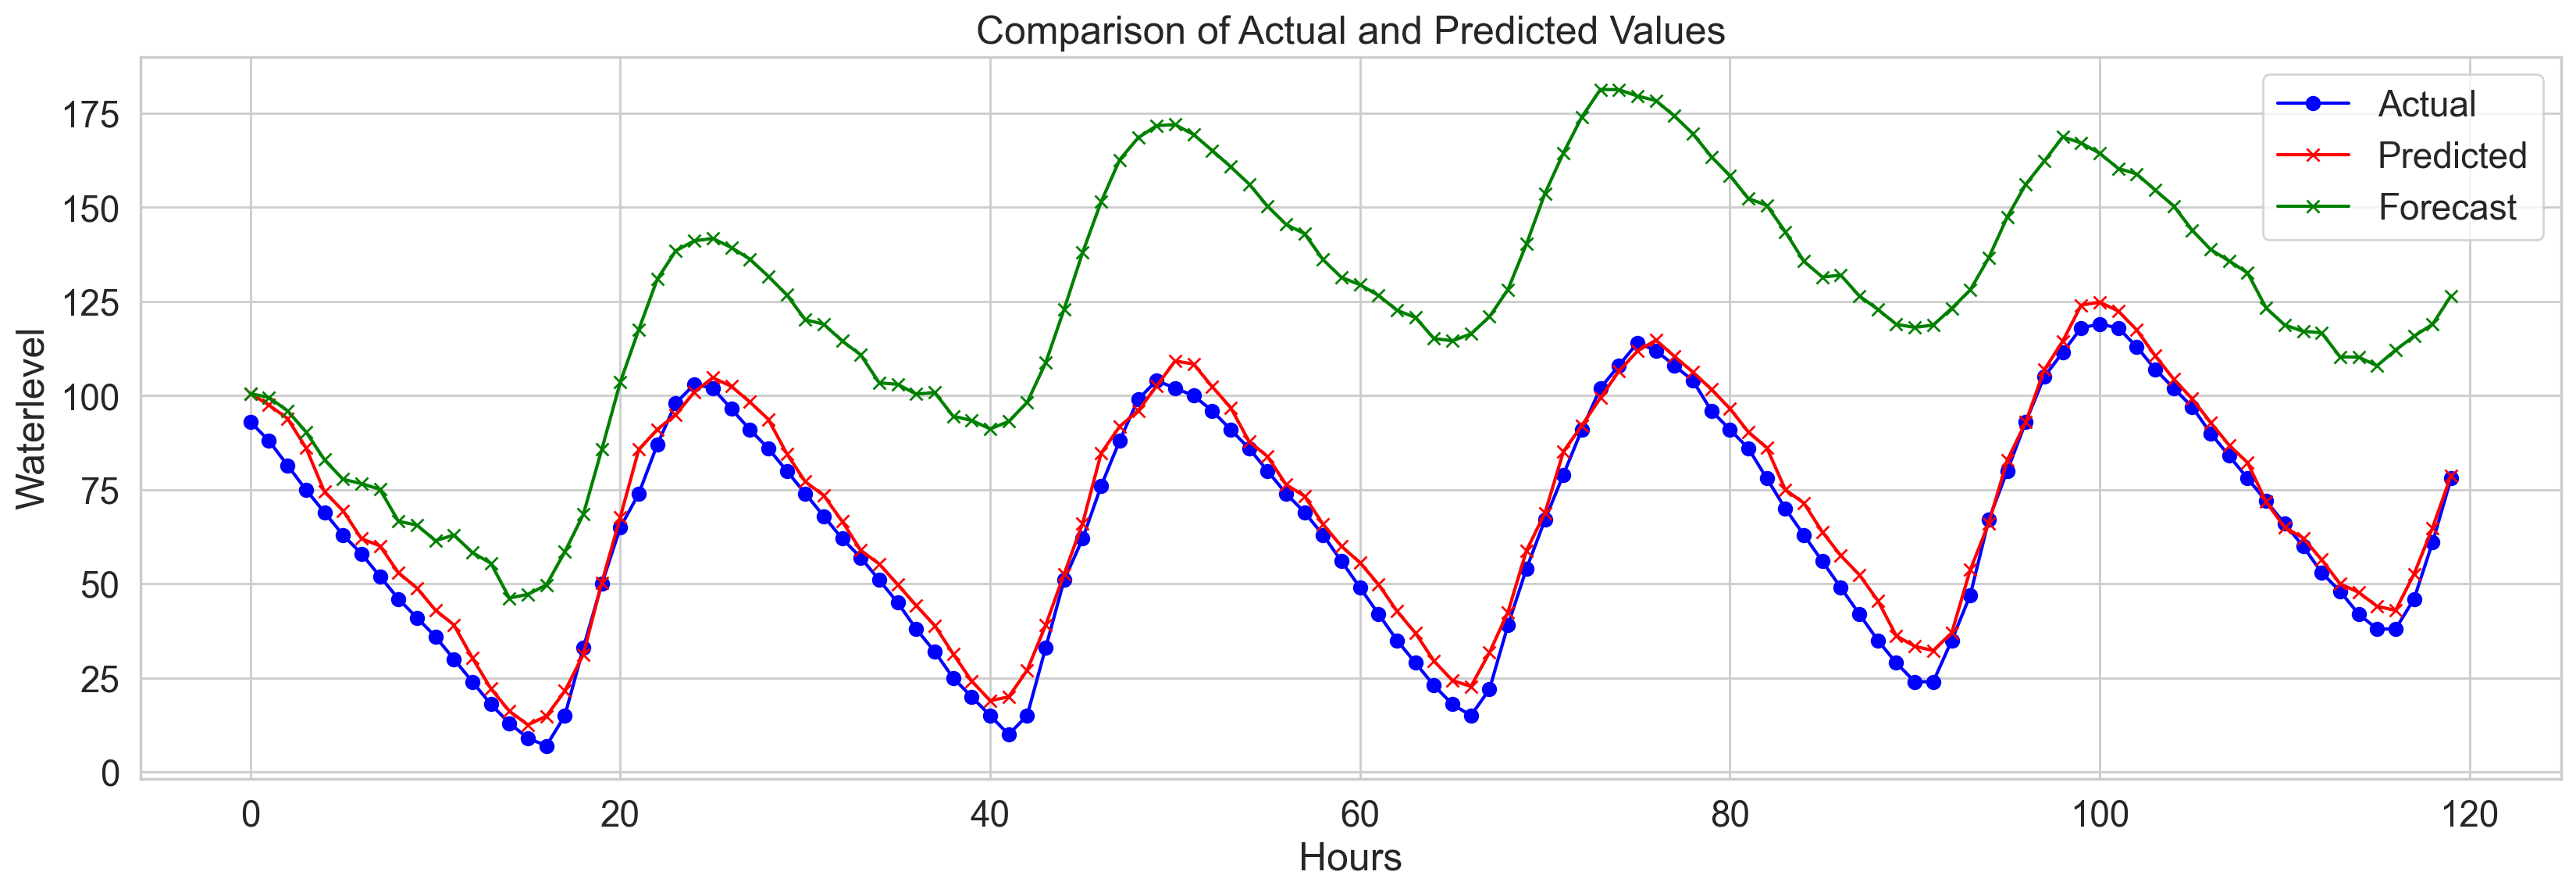

In [39]:
y_fc = forecast(model, hours, time)
y_pred = model.predict(x_test[time:])

y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)
y_fc_original = scaler.inverse_transform(y_fc)

time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    
    plt.figure(figsize=(20, 6))

    plt.plot(y_test_original[time : time + hours].flatten(), label='Actual', color='blue', marker='o')
    plt.plot(y_pred_original[: hours], label='Predicted', color='red', marker='x')
    plt.plot(y_fc_original[: hours].flatten(), label='Forecast', color='green', marker='x')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Hours')
    plt.ylabel('Waterlevel')
    plt.legend()

    plt.show()
    
# for hours in time_forecast:
#     metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
#     for metric, value in metrics.items():
#         print(f'Using model LSTM {hours} hours {metric}: {value}')

#     print('\n')

In [40]:
metrics_df = pd.DataFrame(columns=["Size", "SIM", "MAE", "RMSE", "FSD", "R", "NSE", "MSE"])
for hours in time_forecast:
    
    metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
  
    metrics['Size'] = f'{hours} hours'
    metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)
metrics_df = metrics_df.round(2)    
print(metrics_df.to_string(index=False))


     Size  SIM   MAE  RMSE  FSD    R   NSE     MSE
  3 hours 0.52 11.18 11.54 1.83 0.97 -5.01  133.14
  6 hours 0.70 12.95 13.23 1.96 0.98 -0.61  174.99
 12 hours 0.78 18.59 19.79 1.97 0.99  0.01  391.55
 24 hours 0.77 28.77 31.00 1.99 0.91 -0.23  960.79
 36 hours 0.74 35.08 37.55 1.99 0.90 -0.80 1409.90
 72 hours 0.65 56.73 61.84 1.99 0.70 -3.59 3824.15
120 hours 0.66 60.45 64.16 1.99 0.77 -3.47 4115.96


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4348\3707361921.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)
